# Practical 2: Hierarchical Clustering and linkage measures

**Course:** WBCS032-05 Introduction to Machine Learning  
**Student Names:**  

Rik de Hoop (s5303893) & Avery Kozák (s5559294)
---

## Assignment Overview

In this assignment, you will implement the agglomerative hierarchical clustering algorithm as introduced and discussed in class, using Euclidean distance. Consider

(a) different linkage measures: *single*, *average*, *complete*, and *ward* linkage functions.

(b) three different choices for the number of clusters K = 2, 3, 4.

You will work with the data `data_clustering.csv`, which contains 200
two-dimensional feature vectors. There are no labels associated with the data points.

## 1. Introduction (1 point)

Describe the goal of this assignment.

**Your answer here:**

The goal of this assignment is to understand and apply agglomerative hierarchical clustering on an unlabeled dataset. We investigate how different linkage measures (single, average, complete, and ward) and different numbers of clusters (K = 2, 3, 4) affect the clustering results. Additionally, we implement evaluation metrics such as the silhouette score, within-cluster sum of squares (WSS), and between-cluster sum of squares (BSS) to quantitatively assess clustering quality, and visualize the results using scatter plots and dendrograms.

## 2. Methods (3 points)

### 2.1 Explain agglomerative hierarchical clustering algorithm (0.5 points)

Explain the algorithm in a general manner, including different linkage measures.

**Your answer here:**
Algorithm steps:
- take all points as clusters
- compute the difference between allclusters
- find the clusters witht the smallest distance according to the linkage measure
- merge these two clusters
- update the distance and go bak to computing distance step, until:
- the desired number of clusters has been found

difference in linkage measures:

- single: smallest distance between single points of clusters
- average: distance between the average of points of clusters
- complete: largest difference between points of clusters
- ward: minimizes cluster variance

### 2.2 Implementation (2.5 points)

You are allowed to implement the algorithm using built-in functions from *sklearn* for linkage measures and the dendrogram. You need to implement the evaluation metrics (incl. silhouette score, within-cluster sum of squares and between-cluster sum of squares) **yourself**. Both the code quality and correctness will be graded.

*__Note:__* **Do not change the cell labels! Themis will use them to automatically grade your submission.**

In [40]:
# Load required libraries
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

# Data configuration
data_file_path = 'data_clustering.csv'
df = pd.read_csv(data_file_path, header=None)
data = np.array(df)

# Linkage measures
linkage_measures = ["single", "average", "complete", "ward"]

# The number of clusters
clusters_K = [2, 3, 4]

Write code in the cell below to visualize the input data.

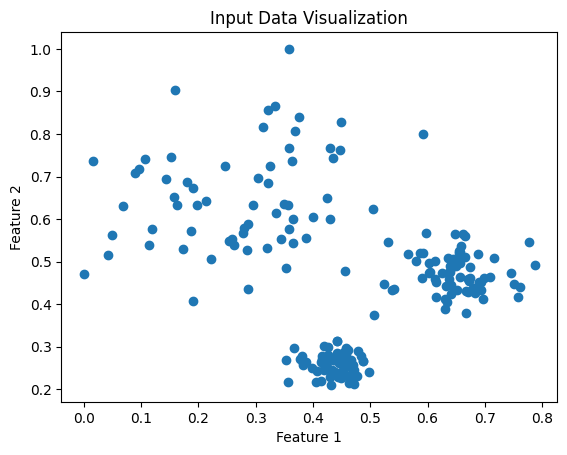

In [41]:
plt.scatter(data[:, 0], data[:, 1])
plt.title("Input Data Visualization")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In the cell below, write code to perform hierarchical clustering using sklearn. Use the different linkage measures and number of clusters specified above. Store the cluster labels for each combination of linkage measure and number of clusters in a dictionary.

In [42]:
all_labels = {}

for linkage_measure in linkage_measures:
    for k in clusters_K:
        model = AgglomerativeClustering(
            n_clusters=k,
            linkage=linkage_measure
        )
        labels = model.fit_predict(data)
        all_labels[(linkage_measure, k)] = labels

# print(all_labels.keys())

In the cells below, complete the implementation of the evaluation metrics (silhouette score, within-cluster sum of squares and between-cluster sum of squares).

In [43]:
def silhouette_score_defined(input_data, labels):
    """
    Compute the self-defined Silhouette Score.

    Args:
        input_data (ndarray): Data points.
        labels (ndarray): Labels of the data points.

    Returns:
        float: The mean silhouette score for all points.
    """
    n = len(input_data)
    unique_labels = np.unique(labels)
    silhouette_values = []
    
    for i in range(n):
        point = input_data[i]
        label_i = labels[i]
        
        same_cluster_indices = np.where(labels == label_i)[0]
        same_cluster_indices = same_cluster_indices[same_cluster_indices != i]
        
        if len(same_cluster_indices) > 0:
            distances = np.linalg.norm(
                input_data[same_cluster_indices] - point,
                axis=1
            )
            a = np.mean(distances)
        else:
            a = 0
        
        b = np.inf
        
        for other_label in unique_labels:
            if other_label == label_i:
                continue
            
            other_cluster_indices = np.where(labels == other_label)[0]
            distances = np.linalg.norm(
                input_data[other_cluster_indices] - point,
                axis=1
            )
            mean_distance = np.mean(distances)
            b = min(b, mean_distance)
        
        if max(a, b) > 0:
            s = (b - a) / max(a, b)
        else:
            s = 0
        
        silhouette_values.append(s)
    
    return np.mean(silhouette_values)

# labels = all_labels[("ward", 3)]
# score = silhouette_score_defined(data, labels)
# print(score)

# print(silhouette_score(data, all_labels[("ward", 3)]))
# running these statements shows that the self defined method is slightly off

In [44]:
def compute_wss_bss(input_data, labels):
    """
    Compute Within-Cluster Sum of Squares (WSS) and Between-Cluster Sum of Squares (BSS).

    Args:
        input_data (ndarray): Data points.
        labels (ndarray): Labels of the data points.
        
    Returns:
        tuple: (WSS, BSS)
    """
    unique_labels = np.unique(labels)
    overall_mean = np.mean(input_data, axis=0)
    
    WSS = 0
    BSS = 0
    
    for label in unique_labels:
        cluster_points = input_data[labels == label]
        n_points = len(cluster_points)
        
        centroid = np.mean(cluster_points, axis=0)
        
        WSS += np.sum((cluster_points - centroid) ** 2)
        
        BSS += n_points * np.sum((centroid - overall_mean) ** 2)
    
    return (WSS, BSS)

# labels = all_labels[("ward", 3)]
# score = compute_wss_bss(data, labels)
# print(score)


## 3. Experimental Results (4 points)

*__Note:__* This section **is graded** by Themis.

### 3.1 Qualitative result

1. Implement `plot_dendrogram(input_data, linkage_measure, cutoff)` - Plot a dendrogram for the given linkage measure and indicate the corresponding cut-off thresholds using dashed horizontal lines.

2. Implement `plot_clustering_results(input_data, k, linkage_measure)` - Plot the clustering results for a given number of clusters and linkage measure.


In [67]:
def plot_dendrogram(input_data, linkage_measure, cutoff):
    """
    Plot a single dendrogram, based on the given parameters.

    Args:
        input_data (ndarray): Data points.
        linkage_measure (str): The linkage measure (e.g. 'single').
        cutoff (list): List of cut-off thresholds.
    """

    dataZ = linkage(input_data, linkage_measure)
    plt.figure()
    dendrogram(dataZ, no_labels=True)
    for t in cutoff:
        plt.axhline(y=t, linestyle='--', color='g')
    plt.title("Dendrogram - " + linkage_measure + " measure")
    plt.xlabel("Observations")
    plt.ylabel("Dissimilarity")

In [ ]:
def plot_clustering_results(input_data, k, linkage_measure):
    """
    Plot clustering results for given k and linkage measure.

    Args:
        input_data (ndarray): Data points.
        k (int): Number of clusters.
        linkage_measure (str): Linkage measure used for clustering.
    """
    
    # calculate our clusters
    cluster = AgglomerativeClustering(k, linkage=linkage_measure)
    labels = cluster.fit(input_data).labels_

    # visualise these using a colour-coded scatterplot
    plt.figure()
    plt.scatter(data[:, 0], data[:, 1], c=labels)
    plt.xlabel("Clustering results for " + str(k) + "clusters, using " + linkage_measure + "measure")

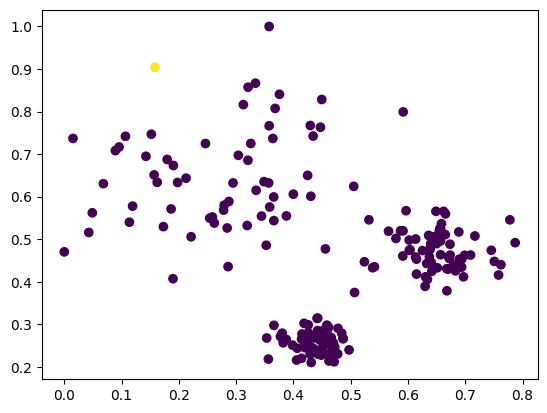

In [75]:
plot_clustering_results(
        input_data = data, 
        linkage_measure = "single", 
        k = 2
    )

### 3.2 Quantitative result

1. Implement `compute_silhouette_scores(input_data, k, linkage_measure)` - Compute and return the silhouette score for the given clustering configuration.

2. Implement `compute_wss_bss_scores(input_data, k, linkage_measure)` - Compute and return the within-cluster sum of squares (WSS) and between-cluster sum of squares (BSS) for the given clustering configuration.

In [47]:
def compute_silhouette_scores(input_data, k, linkage_measure):
    """
    Compute silhouette scores for different clustering results.

    Args:
        input_data (ndarray): Data points.
        k (int): Number of clusters.
        linkage_measure (str): Linkage measure used for clustering.
        
    Returns:
        float: Silhouette score for the given clustering configuration.
    """

    cluster = AgglomerativeClustering(k, linkage=linkage_measure)
    labels = cluster.fit(input_data).labels_
    return silhouette_score_defined(input_data, labels)

In [48]:
def compute_wss_bss_scores(input_data, k, linkage_measure):
    """
    Compute WSS and BSS scores for different clustering results.

    Args:
        input_data (ndarray): Data points.
        k (int): Number of clusters.
        linkage_measure (str): Linkage measure used for clustering.
        
    Returns:
        tuple: WSS and BSS scores for the given clustering configuration.
    """

    cluster = AgglomerativeClustering(k, linkage=linkage_measure)
    labels = cluster.fit(input_data).labels_
    return compute_wss_bss(input_data, labels)

## 4. Discussion (2 points)

Discuss your observations on both the qualitative and quantitative results, and conclusions for the best choice of linkage measures and the number of clusters.

**Your answer here:**

In [49]:
# calculating individual results
for linkage_measure in linkage_measures:
    print("\nFor linkage measure " + str(linkage_measure) + ":")
    for k in clusters_K:
        pair = (linkage_measure, k)
        print("   cluster count " + str(k) + ":")
        #
        silhouette = compute_silhouette_scores(data, k, linkage_measure)
        (wss, bss) = compute_wss_bss_scores(data, k, linkage_measure)
        print("   S   = " + str(round(silhouette, 5)))
        print("   WSS = " + str(round(wss, 5)))
        print("   BSS = " + str(round(bss, 5)) + "\n")


For linkage measure single:
   cluster count 2:
   S   = 0.38233
   WSS = 11.82422
   BSS = 0.28947

   cluster count 3:
   S   = 0.19046
   WSS = 11.68917
   BSS = 0.42452

   cluster count 4:
   S   = 0.20021
   WSS = 11.38033
   BSS = 0.73336


For linkage measure average:
   cluster count 2:
   S   = 0.54124
   WSS = 5.47945
   BSS = 6.63425

   cluster count 3:
   S   = 0.65126
   WSS = 2.40055
   BSS = 9.71315

   cluster count 4:
   S   = 0.62691
   WSS = 1.66098
   BSS = 10.45272


For linkage measure complete:
   cluster count 2:
   S   = 0.46544
   WSS = 7.03899
   BSS = 5.07471

   cluster count 3:
   S   = 0.42071
   WSS = 6.36641
   BSS = 5.74728

   cluster count 4:
   S   = 0.49019
   WSS = 3.2729
   BSS = 8.8408


For linkage measure ward:
   cluster count 2:
   S   = 0.54116
   WSS = 5.47002
   BSS = 6.64367

   cluster count 3:
   S   = 0.65099
   WSS = 2.4145
   BSS = 9.6992

   cluster count 4:
   S   = 0.62508
   WSS = 1.69364
   BSS = 10.42005



As we can see above, the silhouette score is highest across all cluster counts when using Average or Ward linkage measures. 

Note also that for any linkage measure, increasing the cluster count decreases WSS and increases BSS.

A decreasing WSS with increasing cluster counts suggests tighter clusters as we increase their count, which intuitively makes sense. Additionally, an increasing BSS with increasing cluster counts suggests that the resulting clusters are better separated from each other.

The silhouette score, on the other hand, seems to correlate with cluster count in different ways depending on the linkage measure: in some cases being the largest at K=3, while in other cases being the *smallest* at this threshold.

Our highest silhouette score is at cluster count **K=3** with **average** linkage, with a close second being at the same at the same K with **Ward** linkage. In both cases, we have fairly good values for the WSS and BSS (at approx. 2.4 and 9.5 respectively) - in fact, out of all combinations of linkage measure and cluster count, these are among the best out of all WSS and BSS values.

Therefore, given our observations, a **cluster count of 3 with average linkage** seems to fit our data set best.

## Contribution

State your individual contribution.

**Your answer here:**